<a href="https://www.kaggle.com/code/youneseloiarm/mitsui-co-autogluon-with-lags-sub-02?scriptVersionId=261250030" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

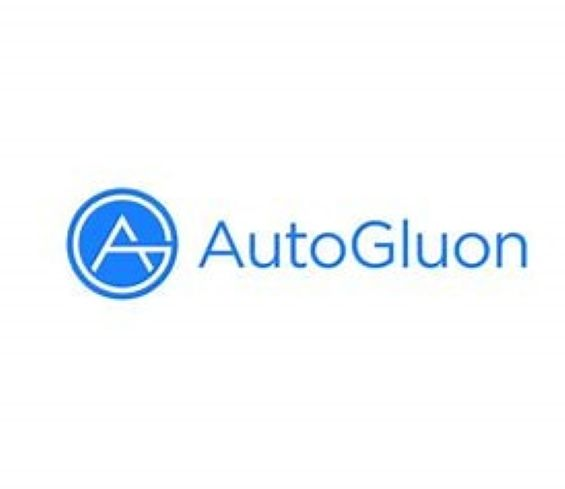

---

**In this notebook, we will use AutoGluon AutoML for a multi-target regression problem, leveraging lagged targets to predict 424 outputs. To speed up inference, we adopt the long-format multi-output prediction method, which is much faster than the standard multi-output approach.**

**You will also find several useful techniques in this notebook, including:**

* How to create lagged targets and use them in the prediction step
* How to run AutoML models offline (without internet access)
* How to build an optimized prediction function for API inference



---


In [1]:
import kaggle_evaluation.mitsui_inference_server
from sklearn import *
import numpy as np
import pandas as pd
import polars as pl
import os, warnings
warnings.filterwarnings("ignore")

p = '/kaggle/input/mitsui-commodity-prediction-challenge/'
train = pd.read_csv(p+'train.csv')
trainl = pd.read_csv(p+'train_labels.csv')
traint = pd.read_csv(p+'target_pairs.csv')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install --no-index --no-deps /kaggle/input/autogluon-new/wheelhouse/autogluon-1.4.0-py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/autogluon-new/wheelhouse/autogluon.common-1.4.0-py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/autogluon-new/wheelhouse/autogluon.core-1.4.0-py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/autogluon-new/wheelhouse/autogluon.features-1.4.0-py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/autogluon-new/wheelhouse/autogluon.multimodal-1.4.0-py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/autogluon-new/wheelhouse/autogluon.tabular-1.4.0-py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/autogluon-new/wheelhouse/autogluon.timeseries-1.4.0-py3-none-any.whl

Processing /kaggle/input/autogluon-new/wheelhouse/autogluon-1.4.0-py3-none-any.whl
Processing /kaggle/input/autogluon-new/wheelhouse/autogluon.common-1.4.0-py3-none-any.whl
Processing /kaggle/input/autogluon-new/wheelhouse/autogluon.core-1.4.0-py3-none-any.whl
Processing /kaggle/input/autogluon-new/wheelhouse/autogluon.features-1.4.0-py3-none-any.whl
Processing /kaggle/input/autogluon-new/wheelhouse/autogluon.multimodal-1.4.0-py3-none-any.whl
Processing /kaggle/input/autogluon-new/wheelhouse/autogluon.tabular-1.4.0-py3-none-any.whl
Processing /kaggle/input/autogluon-new/wheelhouse/autogluon.timeseries-1.4.0-py3-none-any.whl


In [3]:
#!pip install /kaggle/input/tpot-automl/wheelhouse/*.whl

#import glob, subprocess

#for wheel in sorted(glob.glob("/kaggle/input/autogluon-new/wheelhouse/autogluon*.whl")):
    #subprocess.run(["pip", "install", wheel])

In [4]:
from autogluon.tabular import TabularPredictor

In [5]:
trainl = trainl.fillna(0)

In [6]:
target_lag_1 = traint.loc[traint["lag"]==1,"target"].values
target_lag_2 = traint.loc[traint["lag"]==2,"target"].values
target_lag_3 = traint.loc[traint["lag"]==3,"target"].values
target_lag_4 = traint.loc[traint["lag"]==4,"target"].values

In [7]:
Features = [i for i in trainl.columns[1:] ]
def creat_lagged_labels(df):
    dt = pd.DataFrame()
    dt["date_id"] = df["date_id"]
    for f in Features:
        if f in target_lag_1:
            lag = 1
        elif f in target_lag_2:
            lag = 2
        elif f in target_lag_3:
            lag = 3
        elif f in target_lag_4:
            lag = 4    
        dt[f] = df[f].shift(lag).fillna(0)
    return df, dt

In [8]:
_,train_lagged = creat_lagged_labels(trainl)

In [9]:
train_lagged2 = train_lagged[-600:].copy()
trainl2 = trainl[-600:].copy()

In [10]:
# long-format multi-output predictions method:
import gc
training_df = []
target_cols = [f"target_{i}" for i in range(424)]
for j, target_col in enumerate(target_cols):
    temp_train_df = pd.DataFrame()
    temp_train_df[Features]  = train_lagged2[Features]                     
    #temp_train_df = X_trains2.copy()
    temp_train_df['target_id'] = j
    y = trainl2[target_col].values
    temp_train_df['target'] = y
    mask = ~(np.isnan(y) | np.isinf(y) | (np.abs(y) > 1e10))
    training_df.append(temp_train_df[mask].copy())
    del temp_train_df,y
    gc.collect()
training_df = pd.concat(training_df).reset_index(drop=True)

In [11]:
# Memory optimization
def reduce_memory_usage(df):
    """Optimize DataFrame memory usage by downcasting numeric columns."""
    start_mem = df.memory_usage().sum() / 1024**3
    print(f"Starting memory: {start_mem:.2f} GB")
    
    for col in df.select_dtypes(include=['float']).columns:
        col_min = df[col].min()
        col_max = df[col].max()
        
        if col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float16).max:
            df[col] = df[col].astype(np.float16)
        elif col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
            df[col] = df[col].astype(np.float32)
    
    end_mem = df.memory_usage().sum() / 1024**3
    reduction = 100 * (start_mem - end_mem) / start_mem
    print(f"Memory reduced to: {end_mem:.2f} GB ({reduction:.1f}% reduction)")
    return df
training_df = reduce_memory_usage(training_df)

Starting memory: 0.81 GB
Memory reduced to: 0.20 GB (74.8% reduction)


In [12]:
from autogluon.tabular import TabularPredictor

predictor = TabularPredictor.load("/kaggle/input/mitsui-co-autogluon-with-lags-02/")


In [13]:
train_predictions = predictor.predict(training_df)
train_predictions

0        -0.000737
1        -0.000482
2        -0.000445
3        -0.000106
4        -0.000043
            ...   
254395   -0.012027
254396    0.000557
254397   -0.000353
254398    0.000776
254399    0.005920
Name: target, Length: 254400, dtype: float32

In [14]:
X_data = training_df.copy()
X_data["preds"] = train_predictions.values

In [15]:
X_data[["target_id","preds"]]

,target_id,preds
0,0,-0.000737
1,0,-0.000482
2,0,-0.000445
3,0,-0.000106
4,0,-0.000043
...,...,...
254395,423,-0.012027
254396,423,0.000557
254397,423,-0.000353
254398,423,0.000776


In [16]:
# Step 1: Add row ID for test samples (0 to 89 repeated 424 times)
df_preds = X_data.copy()
df_preds['row'] = df_preds.groupby('target_id').cumcount()

# Step 2: Pivot the table to wide format
df_wide = df_preds.pivot(index='row', columns='target_id', values='preds')

# Step 3: Optionally, sort columns by target_id
df_wide = df_wide.sort_index(axis=1)
df_wide.index = [i for i in df_wide.index]
# Step 4: Rename columns (optional)
df_wide.columns = [f'target_{i}' for i in df_wide.columns]
df_wide

,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
0,-0.000737,-0.000554,-0.000478,-0.000559,-0.000992,-0.001001,-0.000814,-0.000758,-0.000786,-0.000592,...,0.001610,0.001319,0.001222,0.002805,0.002842,0.002808,0.003846,0.004098,0.005078,0.001770
1,-0.000482,-0.000487,-0.000334,-0.000399,-0.000366,-0.000400,-0.000406,-0.000392,-0.000453,-0.000451,...,0.003022,0.002600,0.002472,0.000497,0.002725,0.002598,0.002400,0.004400,0.002913,0.000097
2,-0.000445,-0.000446,-0.000438,-0.000399,-0.000445,-0.000450,-0.000441,-0.000396,-0.000440,-0.000448,...,0.001652,0.001100,0.000754,0.000849,0.002284,0.002361,0.003424,0.004421,0.004443,0.002801
3,-0.000106,-0.000114,-0.000096,-0.000096,-0.000096,-0.000096,-0.000109,-0.000130,-0.000130,-0.000130,...,0.000051,0.000038,0.000037,0.000745,0.001002,0.000778,0.000705,0.001244,0.001130,-0.000220
4,-0.000043,-0.000043,-0.000043,-0.000043,-0.000043,-0.000035,-0.000035,-0.000035,-0.000035,-0.000035,...,0.000096,0.000065,0.000115,0.000427,0.000677,0.000623,0.000848,0.000901,0.001214,-0.001938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,-0.000219,-0.000213,-0.000050,-0.000079,-0.000223,-0.000227,-0.000211,-0.000273,-0.000234,-0.000225,...,0.000486,0.000761,0.000800,0.000371,0.000623,0.000711,0.001359,0.000950,0.000434,-0.012027
596,0.000228,0.000176,0.000225,0.000145,-0.000020,-0.000039,0.000177,0.000172,0.000188,0.000339,...,0.001879,0.001281,0.002333,-0.000824,-0.000159,-0.000334,-0.000032,-0.002008,0.002140,0.000557
597,0.000246,0.000247,0.000062,0.000105,0.000242,0.000108,0.000106,0.000111,0.000005,0.000059,...,-0.000239,0.000499,-0.000296,-0.001310,-0.000899,-0.001601,-0.000915,-0.001779,-0.000258,-0.000353
598,-0.000083,-0.000076,-0.000076,-0.000116,-0.000255,-0.000127,0.000029,-0.000109,-0.000114,-0.000115,...,0.001937,0.001397,0.000200,-0.000463,0.002840,0.002828,0.003324,0.003019,0.002980,0.000776


In [17]:
#/www.kaggle.com/code/metric/mitsui-co-commodity-prediction-metric
def rank_correlation_sharpe_ratio(merged_df: pd.DataFrame) -> float:
    prediction_cols = [col for col in merged_df.columns if col.startswith('prediction_')]
    target_cols = [col for col in merged_df.columns if col.startswith('target_')]
    def _compute_rank_correlation(row):
        non_null_targets = [col for col in target_cols if not pd.isnull(row[col])]
        matching_predictions = [col for col in prediction_cols if col.replace('prediction', 'target') in non_null_targets]
        if not non_null_targets:
            raise ValueError('No non-null target values found')
        if row[non_null_targets].std(ddof=0) == 0 or row[matching_predictions].std(ddof=0) == 0:
            raise ZeroDivisionError('Denominator is zero, unable to compute rank correlation.')
        return np.corrcoef(row[matching_predictions].rank(method='average'), row[non_null_targets].rank(method='average'))[0, 1]
    daily_rank_corrs = merged_df.apply(_compute_rank_correlation, axis=1)
    std_dev = daily_rank_corrs.std(ddof=0)
    if std_dev == 0:
        raise ZeroDivisionError('Denominator is zero, unable to compute Sharpe ratio.')
    sharpe_ratio = daily_rank_corrs.mean() / std_dev
    return float(sharpe_ratio)

def score(solution: pd.DataFrame, submission: pd.DataFrame) -> float:
    assert all(solution.columns == submission.columns)
    submission = submission.rename(columns={col: col.replace('target_', 'prediction_') for col in submission.columns})
    solution = solution.replace(0, None)
    return rank_correlation_sharpe_ratio(pd.concat([solution, submission], axis='columns'))

In [18]:
trainl2[Features[1:]]

,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
1361,0.001821,0.018480,-0.000787,-0.028932,-0.043041,0.012657,-0.020624,-0.021405,-0.007235,0.025614,...,0.010973,0.000000,0.000000,0.022754,0.000000,0.000000,0.004530,0.000000,0.036240,0.000000
1362,-0.010400,0.005819,0.003771,0.005047,0.010893,-0.007133,-0.003677,0.009363,0.006784,-0.014830,...,0.011409,-0.008656,0.016508,-0.009595,0.003681,0.002923,-0.008764,0.019141,0.006281,-0.000503
1363,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.025929,-0.020087,0.009405,0.009683,-0.005347,0.004830,0.005506,0.006320,0.021067,0.009988
1364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.034523,0.000000,0.000000,0.000000,0.000000,0.023841,0.000000
1365,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.002109,0.000000,0.001445,...,0.029758,0.000000,0.000000,0.019700,0.000000,0.000000,0.001110,0.000000,0.038361,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1956,-0.004500,-0.001530,-0.003022,0.000000,0.000000,-0.006263,0.001251,0.000000,0.002182,0.000000,...,0.000000,0.010110,0.009248,0.000000,0.009526,0.004318,0.000000,0.005344,0.000000,-0.041391
1957,-0.001036,0.000409,-0.003524,-0.008052,-0.013435,0.013214,-0.008121,0.005308,-0.006430,0.016660,...,-0.006012,-0.007567,0.021569,0.008000,0.015748,-0.001036,0.001043,0.015982,0.004550,-0.028627
1958,-0.002032,0.001083,0.004975,0.016810,0.020511,-0.003176,-0.002232,0.012985,0.007888,-0.025815,...,-0.026047,-0.007783,0.005746,-0.020410,0.026720,0.007130,0.004826,-0.002617,-0.033630,-0.007604
1959,-0.006335,-0.003885,0.002704,-0.004042,-0.001637,0.000142,-0.010872,-0.002934,0.004181,-0.006940,...,-0.006359,-0.006478,0.012228,0.013633,0.022029,0.000092,0.016932,-0.000136,-0.006557,0.009290


In [19]:
df_wide[Features[1:]]

,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
0,-0.000554,-0.000478,-0.000559,-0.000992,-0.001001,-0.000814,-0.000758,-0.000786,-0.000592,-0.000119,...,0.001610,0.001319,0.001222,0.002805,0.002842,0.002808,0.003846,0.004098,0.005078,0.001770
1,-0.000487,-0.000334,-0.000399,-0.000366,-0.000400,-0.000406,-0.000392,-0.000453,-0.000451,-0.000481,...,0.003022,0.002600,0.002472,0.000497,0.002725,0.002598,0.002400,0.004400,0.002913,0.000097
2,-0.000446,-0.000438,-0.000399,-0.000445,-0.000450,-0.000441,-0.000396,-0.000440,-0.000448,-0.000449,...,0.001652,0.001100,0.000754,0.000849,0.002284,0.002361,0.003424,0.004421,0.004443,0.002801
3,-0.000114,-0.000096,-0.000096,-0.000096,-0.000096,-0.000109,-0.000130,-0.000130,-0.000130,-0.000130,...,0.000051,0.000038,0.000037,0.000745,0.001002,0.000778,0.000705,0.001244,0.001130,-0.000220
4,-0.000043,-0.000043,-0.000043,-0.000043,-0.000035,-0.000035,-0.000035,-0.000035,-0.000035,-0.000053,...,0.000096,0.000065,0.000115,0.000427,0.000677,0.000623,0.000848,0.000901,0.001214,-0.001938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,-0.000213,-0.000050,-0.000079,-0.000223,-0.000227,-0.000211,-0.000273,-0.000234,-0.000225,-0.000163,...,0.000486,0.000761,0.000800,0.000371,0.000623,0.000711,0.001359,0.000950,0.000434,-0.012027
596,0.000176,0.000225,0.000145,-0.000020,-0.000039,0.000177,0.000172,0.000188,0.000339,0.000421,...,0.001879,0.001281,0.002333,-0.000824,-0.000159,-0.000334,-0.000032,-0.002008,0.002140,0.000557
597,0.000247,0.000062,0.000105,0.000242,0.000108,0.000106,0.000111,0.000005,0.000059,0.000188,...,-0.000239,0.000499,-0.000296,-0.001310,-0.000899,-0.001601,-0.000915,-0.001779,-0.000258,-0.000353
598,-0.000076,-0.000076,-0.000116,-0.000255,-0.000127,0.000029,-0.000109,-0.000114,-0.000115,0.000059,...,0.001937,0.001397,0.000200,-0.000463,0.002840,0.002828,0.003324,0.003019,0.002980,0.000776


In [20]:
df_wide.index = trainl2.index

In [21]:
score(trainl2[Features[1:]],df_wide[Features[1:]])

2.445201891991177

In [22]:
ycols = ['target_' + str(i) for i in range(424)]
Features2 = [i for i in training_df.columns if i!="target"]

In [23]:
def predict(
    test: pl.DataFrame,
    lag1: pl.DataFrame, 
    lag2: pl.DataFrame,
    lag3: pl.DataFrame,
    lag4: pl.DataFrame,
) -> pl.DataFrame:
    """
    Predicts target values using lag features.
    Handles empty input and replaces null values with 0.
    Optimized for performance by:
    - Minimizing data conversions
    - Using vectorized operations
    - Reducing memory allocations
    - Parallelizing predictions where possible
    """
    # Combine lag features in one operation
    X_pred = pl.concat(
        [   test.select(["date_id"]),
            lag1.select(target_lag_1),
            lag2.select(target_lag_2),
            lag3.select(target_lag_3),
            lag4.select(target_lag_4),
        ],
        how="horizontal"
    )
    # If no rows, return all zeros
    if X_pred.height == 0:
        return pl.DataFrame(0, schema=[(f"target_{i}", pl.Float64) for i in range(424)])
    
    # Fill nulls with 0
    X_pred = X_pred.fill_null(0)
    # Prepare features for prediction in one go
    # Create all target_id combinations without materializing full DataFrame
    n_targets = 424
    n_rows = X_pred.height
    #print(X_pred[Features])
    # Prepare features for all targets at once
    features_array = np.tile(X_pred[Features].to_numpy(), (n_targets, 1))
    target_ids = np.repeat(np.arange(n_targets), n_rows)
    #print(Features)
    # Create final prediction DataFrame efficiently
    X_pred2 = pl.DataFrame({
       "date_id": np.tile(X_pred["date_id"].to_numpy(), n_targets),
       **{feat: features_array[:, i] for i, feat in enumerate(Features)},
       "target_id": target_ids,
       "row": np.tile(np.arange(n_rows), 424)
    })
    #print(X_pred2)
    # Predict in batches for memory efficiency
    #batch_size = 10000
    preds = np.zeros(len(X_pred2))
    #print(X_pred2[Features2])
    test_data = X_pred2[Features2].to_pandas()
    #print(test_data)
    predictions = predictor.predict(test_data)
    #h2o_predictions_df = h2o_predictions.as_data_frame()
    #h2o_predictions_df.values
    X_pred2 = X_pred2.with_columns(pl.Series("preds", predictions.values))
    # Pivot to wide format more efficiently
    df_wide = (
        X_pred2.lazy()
        .group_by(["target_id", "row"])
        .agg(pl.col("preds").first())
        .collect()
        .pivot(index="row", columns="target_id", values="preds")
        .sort("row")
    )

    # Ensure correct column order by sorting by target_id
    col_order = sorted([col for col in df_wide.columns if col != "row"], key=int)
    df_wide = df_wide.select(["row"] + col_order)

    # Rename columns to target_0 ... target_423
    df_wide.columns = ["row"] + [f"target_{i}" for i in range(424)]
    # Get column names in order
    target_cols = [f"target_{i}" for i in range(424)]
    df_wide = df_wide.select(target_cols)
    #print(df_wide)
    # Return last row as predictions
    return df_wide.tail(1).to_pandas()

In [24]:
# submission through the API
import kaggle_evaluation.mitsui_inference_server
inference_server = kaggle_evaluation.mitsui_inference_server.MitsuiInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(('/kaggle/input/mitsui-commodity-prediction-challenge/',))

In [25]:
display(pl.read_parquet('/kaggle/working/submission.parquet'))

date_id,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11,target_12,target_13,target_14,target_15,target_16,target_17,target_18,target_19,target_20,target_21,target_22,target_23,target_24,target_25,target_26,target_27,target_28,target_29,target_30,target_31,target_32,target_33,target_34,target_35,…,target_387,target_388,target_389,target_390,target_391,target_392,target_393,target_394,target_395,target_396,target_397,target_398,target_399,target_400,target_401,target_402,target_403,target_404,target_405,target_406,target_407,target_408,target_409,target_410,target_411,target_412,target_413,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1827,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000111,-0.000106,-0.000106,-0.000106,-0.000106,-0.000106,…,-0.000152,-0.000302,-0.000302,-0.000305,-0.000307,-0.000308,-0.000307,-0.000306,-0.000308,-0.000308,-0.000308,-0.000308,-0.000308,-0.000308,-0.000313,-0.000313,-0.000583,-0.000264,-0.000244,-0.000243,-0.000243,-0.000237,-0.000227,-0.000133,-0.000133,-0.000068,-0.000071,-0.00002,-0.00002,0.000062,0.000326,0.000644,0.000643,0.000649,0.00073,0.000697,0.000803
1828,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000111,-0.000106,-0.000106,-0.000106,-0.000106,-0.000106,…,-0.000152,-0.000302,-0.000302,-0.000305,-0.000307,-0.000308,-0.000307,-0.000306,-0.000308,-0.000308,-0.000308,-0.000308,-0.000308,-0.000308,-0.000313,-0.000313,-0.000583,-0.000264,-0.000244,-0.000243,-0.000243,-0.000237,-0.000227,-0.000133,-0.000133,-0.000068,-0.000071,-0.00002,-0.00002,0.000062,0.000326,0.000644,0.000643,0.000649,0.00073,0.000697,0.000803
1829,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000087,-0.000087,-0.000087,-0.000087,-0.000087,-0.000087,-0.000087,-0.000087,-0.000087,-0.000087,-0.000087,-0.000087,-0.000107,-0.000088,-0.000088,-0.000088,-0.000088,-0.000088,…,-0.000145,-0.000294,-0.000294,-0.000298,-0.0003,-0.000309,-0.000308,-0.000423,-0.000298,-0.000298,-0.000298,-0.000297,-0.000297,-0.000297,-0.000313,-0.000313,-0.000764,-0.000262,-0.000237,-0.000236,-0.000236,-0.000217,-0.000216,-0.000076,-0.000077,-0.000018,-0.000021,-0.000014,-0.000014,0.000097,0.000331,0.00065,0.000648,0.000654,0.000733,0.000655,0.000442
1830,-0.000003,-0.000003,-0.000003,-0.000003,-0.000003,-0.000057,-0.000057,-0.000057,-0.000005,-0.000005,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,4.2454e-7,-0.000003,-0.000003,-0.000003,-0.000003,-0.000003,-0.000003,1.9987e-7,-7.0425e-8,-7.0425e-8,-7.0425e-8,-7.0425e-8,-0.00006,-0.00008,-0.000065,-0.000006,-0.000006,-0.000002,-0.000002,…,-0.000284,-0.001405,-0.000246,-0.000032,-0.00012,-0.000237,-0.000378,-0.000262,-0.000269,-0.000311,-0.000389,-0.000318,-0.000134,-0.000129,-0.000132,-0.000091,0.00007,0.000519,0.000076,0.000078,-0.000128,0.00009,-0.000061,0.000131,0.000129,0.000297,0.000285,0.000294,0.000221,0.000316,0.000554,0.000853,0.000619,0.000502,0.000625,0.000491,0.004437
1831,0.000268,0.000256,0.000265,0.00026,